In [49]:
# import modules
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession

# build spark session and spark context
spark = SparkSession.builder \
        .master("local[4]") \
        .appName("hotel") \
        .getOrCreate()
sc = spark.sparkContext

df = spark.read.csv('hotel_bookings.csv',  inferSchema=True, header = True)

ModuleNotFoundError: No module named 'findspark'

In [2]:
#Parameters for defining code below
target = 'is_canceled'
cancel_label = 1
noncancel_label = 0

In [3]:
from pyspark.sql.functions import col

# replace the strings "NULL" and "NA" with null value
df_withNull = df.replace('NULL', None).replace('NA', None)

# replace null values in 'children' to 0 since there are only 4
df2 = df_withNull.fillna({'children':0})

# replace 'children' datatype to int
df2 = df2.withColumn('children', col('children').cast("Int"))
df2 = df2.withColumn('arrival_date_year', col('arrival_date_year').cast("Int")-2015)

# drop 'company' and 'agent' due to high null count
df2 = df2.drop('agent', 'company','country', 'arrival_date_week_number', 'reservation_status')

In [4]:
# addressing reservation_status_date, which gives the date at which the last 
# reservation status was set. I'm transforming it into number of days since reservation
# status was set, so day of arrival - reservation_status_date
# from pyspark.sql.types import DateType

# convert reservation_status_date into datetype dtype
# temp = df2.withColumn("reservation_status_date", df2["reservation_status_date"].cast(DateType()))

# need to combine arrival_date_year, arrival_date_month, and arrival_date_day_of_month
# into one column and cast it to DateType, then replacing reservation_status_date column
# with number of days since reservation.
# until then, dropping reservation_status_date
df2 = df2 .drop('reservation_status_date')

In [5]:
#numerically encode all columns of type string
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, OneHotEncoderModel, StringIndexer

# list of columns to numerically encode
col_string=['hotel', 'meal','market_segment',
            'distribution_channel','reserved_room_type','assigned_room_type',
            'deposit_type','customer_type','arrival_date_month']

# col_num = list of new column names being changed into numeric
col_num=[x+"_NUMERIC" for x in col_string]+['arrival_date_year']
# don't need to change dates into numeric col_num=col_num+['arrival_date_year','arrival_date_day_of_month']

# col_oh = list of columns being one-hot encoded
col_oh=[x+"_oh" for x in col_string]+['arrival_date_year_oh']
# dont need to ohencode dates col_oh=col_oh+['arrival_date_year_oh','arrival_date_day_of_month_oh']

In [6]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_NUMERIC").fit(df2) for column in col_string]
pipeline = Pipeline(stages=indexers)
df_indexed = pipeline.fit(df2).transform(df2)

In [7]:
#one-hot encode all columns in col_num
ohe = OneHotEncoder(dropLast=False)
ohe.setInputCols(col_num)
ohe.setOutputCols(col_oh)
model = ohe.fit(df_indexed)

df_casted=model.transform(df_indexed)

In [8]:
# drop the original, non-ohencoded variables
df_encoded=df_casted.drop(*col_string)
df_encoded=df_encoded.drop(*col_num)

In [9]:
#removed normalization step for now
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import Normalizer

norm_to_columns = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 
                'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'adr', 
                'required_car_parking_spaces', 'total_of_special_requests']

# combine all to-norm columns into one vector named "norm_features"
assembler = VectorAssembler(inputCols=norm_to_columns, outputCol="norm_features")
transformed = assembler.transform(df_encoded) 
transformed = transformed.drop(*norm_to_columns)

# in the end, new column named normFeatures combined all features that are normalized
normalizer = Normalizer(inputCol="norm_features", outputCol="normFeatures", p=1.0)
l1NormData = normalizer.transform(transformed)
l1NormData = l1NormData.drop(*norm_to_columns + ['norm_features'])
print("Normalized using L^1 norm")

Normalized using L^1 norm


In [10]:
# combine all feature columns (non-label columns) into one vector named "feature"
assembler = VectorAssembler(inputCols=df_encoded.columns[1:], outputCol="features")
all_transformed = assembler.transform(df_encoded)

# convert to rdd with 2 columns, label and features, where features is a DenseVector combination of all other features
dataRdd = all_transformed.select(col("is_canceled").alias("label"), col("features")).rdd.map(tuple)

In [11]:
from pyspark.mllib.regression import LabeledPoint

# map features as floats, then input all into a DenseVector, as well as mapping labels as floats
# then map into LabeledPoint object
lp = dataRdd.map(lambda row: (float(row[0]), Vectors.dense([float(c) for c in row[1]])))\
            .map(lambda row: LabeledPoint(row[0], row[1]))
lp.take(1)

[LabeledPoint(0.0, [342.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])]

In [12]:
# 70/30 test train split
seed = 314
train, test = lp.randomSplit([0.7, 0.3], seed=seed)

In [13]:
# use these variables in place of test/train.count() bc those methods take a long time, instead just call once
test_count = test.count()
train_count = train.count()

In [14]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.evaluation import BinaryClassificationMetrics


### Logistic Regression

In [15]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS

# train logistic regression model with training data
model = LogisticRegressionWithLBFGS.train(train)

In [16]:
# Evaluating the model on test data
labelsAndPreds_te = test.map(lambda p: (p.label, float(model.predict(p.features))))
accuracy_te = 1.0 * labelsAndPreds_te.filter(lambda pl: pl[0] == pl[1]).count() / test_count
print('model accuracy (test): {}'.format(accuracy_te))

model accuracy (test): 0.812790893287725


#### Logistic with intercept

In [17]:
model_lr_int = LogisticRegressionWithLBFGS.train(train, intercept=True)


In [18]:
# Evaluating the model on test data
labelsAndPreds_te_int = test.map(lambda p: (p.label, model_lr_int.predict(p.features)))
accuracy_te_int = 1.0 * labelsAndPreds_te_int.filter(lambda pl: pl[0] == pl[1]).count() / test_count
print('model accuracy (test): {}'.format(accuracy_te_int))

model accuracy (test): 0.8131834239892335


#### Logistic with interations=10

In [19]:
model_lr_it10 = LogisticRegressionWithLBFGS.train(train, iterations=10)



In [20]:
# Evaluating the model on test data
labelsAndPreds_te_it10 = test.map(lambda p: (p.label, model_lr_it10.predict(p.features)))
accuracy_te_it10 = 1.0 * labelsAndPreds_te_it10.filter(lambda pl: pl[0] == pl[1]).count() / test_count
print('model accuracy (test): {}'.format(accuracy_te_it10))

model accuracy (test): 0.802557057141255


#### Logistic with intercept and interactions=10

In [21]:
model_lr_it10_int = LogisticRegressionWithLBFGS.train(train, iterations=10, intercept=True)


In [22]:
# Evaluating the model on test data
labelsAndPreds_te_it10_int = test.map(lambda p: (p.label, model_lr_it10_int.predict(p.features)))
accuracy_te_it10_int = 1.0 * labelsAndPreds_te_it10_int.filter(lambda pl: pl[0] == pl[1]).count() / test_count
print('model accuracy (test): {}'.format(accuracy_te_it10_int))

model accuracy (test): 0.8009588964279706


In [23]:
metrix1 = MulticlassMetrics(labelsAndPreds_te)
con_metrix1=metrix1.confusionMatrix().toArray()

print('Confusion matrix')
print(con_metrix1)

FN1=metrix1.falsePositiveRate(0.0)
FP1=metrix1.falsePositiveRate(1.0)

print('False negative rate {:2.2%}'.format(FN1))
print('False positive rate {:2.2%}'.format(FP1))

precision1=metrix1.precision(1.0)
recall1=metrix1.recall(1.0)

print('Precision(TP/all positives) {:2.2%}'.format(precision1))
print('Recall(TP/all positive ground truth) {:0.2%}'.format(recall1))


metrics_tr1 = BinaryClassificationMetrics(labelsAndPreds_te)

print("Area under PR for Linear regression = {:2.2%}".format(metrics_tr1.areaUnderPR))

# Area under ROC curve for training data
print("Area under ROC for Linear regression = {:2.2%}".format(metrics_tr1.areaUnderROC))

Confusion matrix
[[20793.  5024.]
 [ 1653.  8196.]]
False negative rate 16.78%
False positive rate 19.46%
Precision(TP/all positives) 62.00%
Recall(TP/all positive ground truth) 83.22%
Area under PR for Linear regression = 59.11%
Area under ROC for Linear regression = 81.88%


In [44]:
labelsAndPreds_te

PythonRDD[662] at RDD at PythonRDD.scala:53

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Let's use the run-of-the-mill evaluator
evaluator = BinaryClassificationEvaluator(labelCol='Survived')

# We have only two choices: area under ROC and PR curves :-(
auroc = evaluator.evaluate(labelsAndPreds_te, {evaluator.metricName: "areaUnderROC"})
auprc = evaluator.evaluate(labelsAndPreds_te, {evaluator.metricName: "areaUnderPR"})
print("Area under ROC Curve: {:.4f}".format(auroc))
print("Area under PR Curve: {:.4f}".format(auprc))

Area under ROC Curve: 0.8188
Area under PR Curve: 0.5911


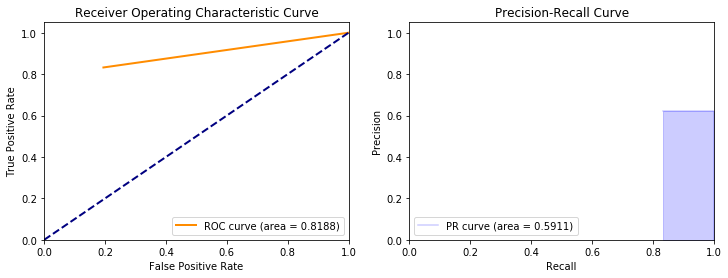

In [58]:
import findspark
from pyspark.sql import SparkSession
from handyspark import *
from matplotlib import pyplot as plt
%matplotlib inline

from pyspark.ml.evaluation import BinaryClassificationEvaluator


from pyspark.sql import SparkSession
from matplotlib import pyplot as plt

# Creates instance of extended version of BinaryClassificationMetrics
# using a DataFrame and its probability and label columns, as the output
# from the classifier
bcm = BinaryClassificationMetrics(labelsAndPreds_te)

# We still can get the same metrics as the evaluator...
print("Area under ROC Curve: {:.4f}".format(bcm.areaUnderROC))
print("Area under PR Curve: {:.4f}".format(bcm.areaUnderPR))

# But now we can PLOT both ROC and PR curves!
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
bcm.plot_roc_curve(ax=axs[0])
bcm.plot_pr_curve(ax=axs[1])




### Random Forest

In [24]:
from pyspark.mllib.util import MLUtils

In [25]:
# converting to LibSVM file
MLUtils.saveAsLibSVMFile(lp, "libsvm.txt")


In [26]:

data = MLUtils.loadLibSVMFile(sc, 'libsvm.txt')
data.take(1)

[LabeledPoint(0.0, (79,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78],[77.0,20.0,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,169.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]))]

In [27]:
# 70/30 test train split for libsvm data
seed = 314
train_sparse, test_sparse = data.randomSplit([0.7, 0.3], seed=seed)

In [28]:
from pyspark.mllib.tree import RandomForest, RandomForestModel

# Train a RandomForest model.
#  Empty categoricalFeaturesInfo indicates all features are continuous.
#  Setting featureSubsetStrategy="auto" lets the algorithm choose.
model_rf = RandomForest.trainClassifier(train_sparse, numClasses=2, categoricalFeaturesInfo={},
                                     numTrees=3, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=5, maxBins=32)

In [29]:
# Evaluate model on test instances and compute test error
predictions = model_rf.predict(test_sparse.map(lambda x: x.features))
labelsAndPreds_te2 = test_sparse.map(lambda lp: lp.label).zip(predictions)
# labelsAndPreds_te3 = test_sparse.map(lambda p: (p.label, float(model_rf.predict(p.features))))


accuracy_te2 = 1.0 * labelsAndPreds_te2.filter(lambda pl: pl[0] == pl[1]).count() / test_count
print('model accuracy (test): {}'.format(accuracy_te2))

model accuracy (test): 0.7532383782874447


In [30]:
metrix2 = MulticlassMetrics(labelsAndPreds_te2)
con_metrix2=metrix2.confusionMatrix().toArray()

print('Confusion matrix')
print(con_metrix2)

FN2=metrix1.falsePositiveRate(0.0)
FP2=metrix1.falsePositiveRate(1.0)

print('False negative rate {:2.2%}'.format(FN2))
print('False positive rate {:2.2%}'.format(FP2))

precision2=metrix2.precision(1.0)
recall2=metrix2.recall(1.0)

print('Precision(TP/all positives) {:2.2%}'.format(precision2))
print('Recall(TP/all positive ground truth) {:0.2%}'.format(recall2))


metrics_tr2 = BinaryClassificationMetrics(labelsAndPreds_te2)

print("Area under PR for Linear regression = {:2.2%}".format(metrics_tr2.areaUnderPR))

# Area under ROC curve for training data
print("Area under ROC for Linear regression = {:2.2%}".format(metrics_tr2.areaUnderROC))

Confusion matrix
[[2.2385e+04 8.8890e+03]
 [1.6000e+01 4.4800e+03]]
False negative rate 16.78%
False positive rate 19.46%
Precision(TP/all positives) 33.51%
Recall(TP/all positive ground truth) 99.64%
Area under PR for Linear regression = 33.47%
Area under ROC for Linear regression = 85.61%


Area under ROC Curve: 0.8561
Area under PR Curve: 0.3347


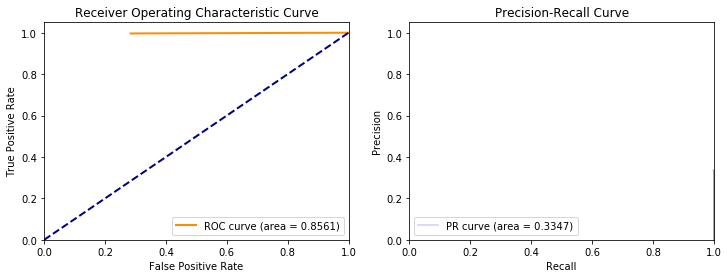

In [59]:
import findspark
from pyspark.sql import SparkSession
from handyspark import *
from matplotlib import pyplot as plt
%matplotlib inline

from pyspark.ml.evaluation import BinaryClassificationEvaluator


from pyspark.sql import SparkSession
from matplotlib import pyplot as plt

# Creates instance of extended version of BinaryClassificationMetrics
# using a DataFrame and its probability and label columns, as the output
# from the classifier
bcm1 = BinaryClassificationMetrics(labelsAndPreds_te2)

# We still can get the same metrics as the evaluator...
print("Area under ROC Curve: {:.4f}".format(bcm1.areaUnderROC))
print("Area under PR Curve: {:.4f}".format(bcm1.areaUnderPR))

# But now we can PLOT both ROC and PR curves!
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
bcm1.plot_roc_curve(ax=axs[0])
bcm1.plot_pr_curve(ax=axs[1])

### SVM

In [31]:
from pyspark.mllib.classification import SVMWithSGD

model_svm = SVMWithSGD.train(train,iterations=10)

labelsAndPreds_te3 = test.map(lambda p: (p.label, float(model_svm.predict(p.features))))
accuracy_te3 = 1.0 * labelsAndPreds_te3.filter(lambda pl: pl[0] == pl[1]).count() / test_count
print('model accuracy (test): {}'.format(accuracy_te3))

model accuracy (test): 0.5877586496943868


In [32]:
metrix3 = MulticlassMetrics(labelsAndPreds_te3)
con_metrix3=metrix3.confusionMatrix().toArray()

print('Confusion matrix')
print(con_metrix3)

FN3=metrix3.falsePositiveRate(0.0)
FP3=metrix3.falsePositiveRate(1.0)

print('False negative rate {:2.2%}'.format(FN3))
print('False positive rate {:2.2%}'.format(FP3))

precision3=metrix3.precision(1.0)
recall3=metrix3.recall(1.0)

print('Precision(TP/all positives) {:2.2%}'.format(precision3))
print('Recall(TP/all positive ground truth) {:0.2%}'.format(recall3))

metrics_tr3 = BinaryClassificationMetrics(labelsAndPreds_te3)

print("Area under PR for Linear regression = {:2.2%}".format(metrics_tr3.areaUnderPR))

# Area under ROC curve for training data
print("Area under ROC for Linear regression = {:2.2%}".format(metrics_tr3.areaUnderROC))

Confusion matrix
[[11345.  3602.]
 [11101.  9618.]]
False negative rate 53.58%
False positive rate 24.10%
Precision(TP/all positives) 72.75%
Recall(TP/all positive ground truth) 46.42%
Area under PR for Linear regression = 68.83%
Area under ROC for Linear regression = 61.16%


Area under ROC Curve: 0.6116
Area under PR Curve: 0.6883


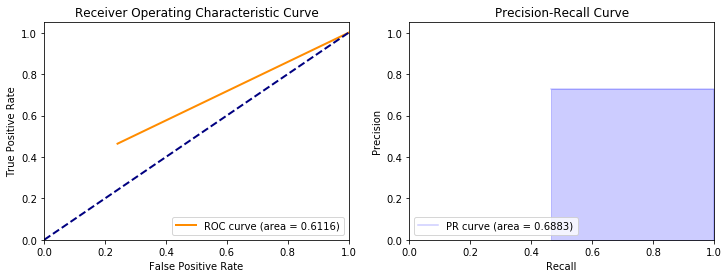

In [60]:
import findspark
from pyspark.sql import SparkSession
from handyspark import *
from matplotlib import pyplot as plt
%matplotlib inline

from pyspark.ml.evaluation import BinaryClassificationEvaluator


from pyspark.sql import SparkSession
from matplotlib import pyplot as plt

# Creates instance of extended version of BinaryClassificationMetrics
# using a DataFrame and its probability and label columns, as the output
# from the classifier
bcm2 = BinaryClassificationMetrics(labelsAndPreds_te3)

# We still can get the same metrics as the evaluator...
print("Area under ROC Curve: {:.4f}".format(bcm2.areaUnderROC))
print("Area under PR Curve: {:.4f}".format(bcm2.areaUnderPR))

# But now we can PLOT both ROC and PR curves!
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
bcm2.plot_roc_curve(ax=axs[0])
bcm2.plot_pr_curve(ax=axs[1])